In [1133]:
import math
import sys
import os
import pandas as pd
import time
import numpy as np
import copy
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from matplotlib import cm as cm
%matplotlib inline

from sklearn.model_selection import train_test_split,StratifiedKFold
from collections import deque

# Exploration of the transformer network

d_model = the dimensions of the model

In [150]:
class Embedder(nn.Module):
    def __init__(self,vocab_size,d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,d_model)
    def forward(self,x):
        return self.embed(x)

In [402]:
class positionalEncoder(nn.Module):
    def __init__(self,d_model, max_seq_len = 80):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(maxlen_seq,d_model)
        for pos in range(maxlen):
            for i in range(0,d_model,2):
                pe[pos,i] = pos / math.sin(10000 ** ((2*i)/d_model))
                pe[pos,i+1] = pos / math.cos(10000 ** ((2*(i+1))/d_model))
        pe.unsqueeze(0)
        self.register_buffer('pe',pe)
        
    def forward(self,x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + Variable(pe[:,:seq_len],requires_grad=False).cuda()
        return x

In [1]:
# for pos in range(10):
#     for i in range(0,10,2):
#         print(pos / math.sin(10000 ** ((2*i))/512))

# Input mask

In [ ]:
batch = next(iter(train_iter))
input_seq = batch.English.transpose(0,1)
input_pad = EN_TEXT.vocab.stoi['<pad>']
# creates mask with 0s wherever there is padding in the input
input_msk = (input_seq != input_pad).unsqueeze(1)

# Target mask

In [ ]:
# create mask as before
target_seq = batch.French.transpose(0,1)
target_pad = FR_TEXT.vocab.stoi['<pad>']
target_msk = (target_seq != target_pad).unsqueeze(1)
size = target_seq.size(1) # get seq_len for matrix
nopeak_mask = np.triu(np.ones(1, size, size),
k=1).astype('uint8')
nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0)
target_msk = target_msk & nopeak_mask

# Attention Head

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
# calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

NameError: name 'nn' is not defined

In [ ]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [ ]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [ ]:
# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model).cuda()
def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
        src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        x = self.embed(src)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function

In [ ]:
d_model = 512
heads = 8
N = 6
src_vocab = len(EN_TEXT.vocab)
trg_vocab = len(FR_TEXT.vocab)
model = Transformer(src_vocab, trg_vocab, d_model, N, heads)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
# this code is very important! It initialises the parameters with a
# range of values that stops the signal fading or getting too big.
# See this blog for a mathematical explanation.
optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
def train_model(epochs, print_every=100):
    
    model.train()
    
    start = time.time()
    temp = start
    
    total_loss = 0
    
    for epoch in range(epochs):
       
        for i, batch in enumerate(train_iter):
            src = batch.English.transpose(0,1)
            trg = batch.French.transpose(0,1)
            # the French sentence we input has all words except
            # the last, as it is using each word to predict the next
            
            trg_input = trg[:, :-1]
            
            # the words we are trying to predict
            
            targets = trg[:, 1:].contiguous().view(-1)
            
            # create function to make masks using mask code above
            
            src_mask, trg_mask = create_masks(src, trg_input)
            
            preds = model(src, trg_input, src_mask, trg_mask)
            
            optim.zero_grad()
            
            loss = F.cross_entropy(preds.view(-1, preds.size(-1)),
            results, ignore_index=target_pad)
            loss.backward()
            optim.step()
            
            total_loss += loss.data[0]
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                print("time = %dm, epoch %d, iter = %d, loss = %.3f,
                %ds per %d iters" % ((time.time() - start) // 60,
                epoch + 1, i + 1, loss_avg, time.time() - temp,
                print_every)
                total_loss = 0
                temp = time.time()

In [ ]:
def translate(model, src, max_len = 80, custom_string=False):
    
    model.eval()
    if custom_sentence == True:
        src = tokenize_en(src)
        sentence=\
        Variable(torch.LongTensor([[EN_TEXT.vocab.stoi[tok] for tok
        in sentence]])).cuda()
    src_mask = (src != input_pad).unsqueeze(-2)
    e_outputs = model.encoder(src, src_mask)
    
    outputs = torch.zeros(max_len).type_as(src.data)
    outputs[0] = torch.LongTensor([FR_TEXT.vocab.stoi['<sos>']])
    for i in range(1, max_len):    
            
        trg_mask = np.triu(np.ones((1, i, i),
        k=1).astype('uint8')
        trg_mask= Variable(torch.from_numpy(trg_mask) == 0).cuda()
        
        out = model.out(model.decoder(outputs[:i].unsqueeze(0),
        e_outputs, src_mask, trg_mask))
        out = F.softmax(out, dim=-1)
        val, ix = out[:, -1].data.topk(1)
        
        outputs[i] = ix[0][0]
        if ix[0][0] == FR_TEXT.vocab.stoi['<eos>']:
            break
    return ' '.join(
    [FR_TEXT.vocab.itos[ix] for ix in outputs[:i]]
    )

# Testing the transformer's performance on a time series dataset

Taken from http://www.ercot.com/gridinfo/load/load_hist/

### The Data

- Label: ERCOT. 
- Use 2018 as test and 2009-2017 as training
- Divide ERCOT by 1000
- 1hot encode the day of the week
- Keep year and hour the same
- 11 Features total
- Use previous 24 hours to predict the next 12 hours

Year,day,hour,load

Don't understand how he had 11 features.
Going to try with 3 (Month,Day,Hour) and see how that works.


In [12]:
folder = '/Users/morgan/Code/Data'

In [29]:
training_set = []
test_set = []

for excel_file in os.listdir(folder):
    if excel_file != '.DS_Store':
        print(excel_file)
        df = pd.read_excel(folder+'/'+excel_file)
        if excel_file == '2014_ERCOT_Hourly_Load_Data.xls':
            test_set.append(df)
        else:
            training_set.append(df)
#         df_dict[i] = 
# self.df_dict = df_dict
# df2009 = pd.read_excel('/Users/morgan/Code/Data/2009_ERCOT_Hourly_Load_Data.xls')

2010_ERCOT_Hourly_Load_Data.xls
2011_ERCOT_Hourly_Load_Data.xls
2013_ERCOT_Hourly_Load_Data.xls
2009_ERCOT_Hourly_Load_Data.xls
2014_ERCOT_Hourly_Load_Data.xls
2012_ERCOT_Hourly_Load_Data.xls


In [34]:
training_df = pd.concat(training_set,axis=0)
test_df = test_set[0]

In [40]:
print('TRAINING \n',training_df.head(2))
print('TEST \n',test_df.head(2))

TRAINING 
                  Hour_End        COAST         EAST     FAR_WEST       NORTH  \
0 2010-01-01 01:00:00.003  7775.456846  1238.179861  1237.649967  877.672404   
1 2010-01-01 01:59:59.997  7704.815982  1236.050964  1248.907364  883.621724   

        NORTH_C     SOUTHERN      SOUTH_C         WEST         ERCOT  
0  12405.849409  2467.581039  5031.931981  1059.742927  32094.064435  
1  12485.814858  2436.025369  5111.468920  1064.617365  32171.322546  
TEST 
                  Hour_End        COAST         EAST     FAR_WEST       NORTH  \
0 2014-01-01 01:00:00.003  9101.691219  1338.197939  1820.206244  793.458458   
1 2014-01-01 01:59:59.997  8907.975782  1328.940064  1809.180861  791.141630   

        NORTH_C     SOUTHERN      SOUTH_C         WEST         ERCOT  
0  12298.801147  3236.109065  6121.146143  1102.523505  35812.133719  
1  12297.109823  3246.493375  6091.018850  1098.774771  35570.635156  


In [37]:
print(training_df.shape)
print(test_df.shape)

(43824, 10)
(8760, 10)


In [85]:
df.head(5)

,Hour_End,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,ERCOT
0,2012-01-01 01:00:00.003,7748.160500,878.438488,1289.746813,652.153054,8648.989316,2105.379142,4162.162310,849.000892,26334.030515
1,2012-01-01 01:59:59.997,7559.728089,839.092904,1294.272245,643.483530,8553.212708,2047.755534,4070.416593,845.097363,25853.058967
2,2012-01-01 03:00:00.000,7337.789042,817.995707,1296.491345,631.940923,8461.317967,1961.909818,3946.994332,840.902848,25295.341984
3,2012-01-01 04:00:00.003,7161.895539,814.967883,1297.417294,631.428520,8438.693857,1893.148232,3884.929253,845.452257,24967.932835
4,2012-01-01 04:59:59.997,6984.460743,843.952579,1309.534911,640.892563,8565.433348,1867.358425,3911.610238,862.369386,24985.612193


In [94]:
df.Hour_End.iloc[4].minute

59

# Generate train and test set

1 hot encode the day.

The minutes need to be checked to round up the hour if necessary.

In [1178]:
def vectorized_dayofweek(d,m,y):
    t = np.array([0,3,2,5,0,3,5,1,4,6,2,4])
    y = np.subtract(y,m<3)
    return np.mod(np.add(np.add(np.add(np.subtract(np.add(y,np.divide(y,4).astype(int)),np.divide(y,100).astype(int)),np.divide(y,400).astype(int)),t[m-1]),d),7)

def return_ml_inputs(df):
    N = df.shape[0]
    hours = df.Hour_End.dt.hour
    minutes = df.Hour_End.dt.minute
    days = df.Hour_End.dt.day
    months = df.Hour_End.dt.month
    years = df.Hour_End.dt.year
    np_months = months.values
    np_energy = df.ERCOT.values / 1000
    # Increment hour values where minutes are 59
    np_minutes = minutes.values
    np_hours = hours.values
    minute_mask = np.where(np_minutes>0)
    np_hours[minute_mask] += 1
    # Encode days of the week 0-6
    encodedDays = vectorized_dayofweek(days.values,months.values,years.values)
    encodedDays = encodedDays[...,None]
    np_hours = np_hours[...,None]
    np_months = np_months[...,None]
    np_energy = np_energy[...,None]
    print(encodedDays.shape,np_hours.shape,np_energy.shape,np_months.shape)
    ml_inputs = np.concatenate([np_hours,encodedDays,np_months,np_energy],axis=1)
    return ml_inputs
    

In [1179]:
training_N = training_df.shape[0]
test_N = test_df.shape[0]
print('training_N',training_N)
print('test_N',test_N)

training_N 43824
test_N 8760


In [1180]:
ml_train = return_ml_inputs(training_df)

(43824, 1) (43824, 1) (43824, 1) (43824, 1)


In [1181]:
ml_test = return_ml_inputs(test_df)

(8760, 1) (8760, 1) (8760, 1) (8760, 1)


In [1182]:
print(ml_train.shape)
print(ml_test.shape)
print(ml_train[0])

(43824, 4)
(8760, 4)
[ 1.          5.          1.         32.09406444]


# Build the data loader

In [1244]:
class seqDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, X):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = torch.from_numpy(X)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {'seq': self.X[idx]}
        return sample

In [1236]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)
X_train = ml_train
X_test = ml_test

In [1237]:
print(X_train.shape,X_test.shape)

(43824, 4) (8760, 4)


# Cut up the dataset into chunks of 36

In [1238]:
def get_minibatches(data,length):
    N = data.shape[0]
    print('N',N)
    batches = []
    for i in range(0,N-length):
        batches.append(data[None,i:i+length,:])
    return np.vstack(batches)

In [1239]:
Xtrain_batches = get_minibatches(X_train,36)
Xtest_batches = get_minibatches(X_test,36)

N 43824
N 8760


In [1240]:
print(Xtrain_batches.shape)
print(Xtest_batches.shape)

(43788, 36, 4)
(8724, 36, 4)


# Convert into dataloader

In [1315]:
trainset = seqDataset(Xtrain_batches)
# valset = seqDataset(X_val,y_val)
testset = seqDataset(Xtest_batches)

trainloader = DataLoader(trainset, batch_size=512,
                        shuffle=False, num_workers=4)
# valloader = DataLoader(valset, batch_size=512,
#                         shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=512,
                        shuffle=False, num_workers=4)

In [1316]:
data_dict = {
    'trainset':trainloader,
    'testset':testloader
}

In [1317]:
d = data_dict['trainset']
print(next(iter(d))['seq'].size())

torch.Size([512, 36, 4])


# Build the transformer

In [1309]:
class Embedder(nn.Module):
    def __init__(self,vocab_size,d_model):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,d_model)
    def forward(self,x):
        return self.embed(x)

class PositionalEncoder(nn.Module):
    def __init__(self,d_model, maxlen_seq = 24):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(maxlen_seq,d_model)
        for pos in range(maxlen_seq):
            for i in range(0,d_model,2):
                pe[pos,i] = pos / math.sin(10000 ** ((2*i)/d_model))
                pe[pos,i+1] = pos / math.cos(10000 ** ((2*(i+1))/d_model))
        pe.unsqueeze(0)
        self.register_buffer('pe',pe)
        
    def forward(self,x):
        x = x * math.sqrt(self.d_model)
        seq_len = x.size(1)
        x = x + Variable(self.pe[:seq_len,:self.d_model],requires_grad=False)
        return x
    
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output
    
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    # No softmax for regression target
    # scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
    
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
    def forward(self, x, e_outputs, src_mask, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs,
        src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x
# We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    def __init__(self, vocab_dict, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embedHour = Embedder(vocab_dict['hour'], 85)
        self.embedDay = Embedder(vocab_dict['day'], 85)
        self.embedMonth = Embedder(vocab_dict['month'], 85)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask):
        hour = src[:,:,0].long()
        day = src[:,:,1].long()
        month = src[:,:,2].long()
        target = src[:,:,3].float().unsqueeze(-1)
        hour = self.embedHour(hour)
        day = self.embedDay(day)
        month = self.embedMonth(month)
        x = torch.cat((hour,day,month,target),dim=-1)
        x = self.pe(x)
        for i in range(N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_dict, d_model, N, heads):
        super().__init__()
        self.N = N
        self.embedHour = Embedder(vocab_dict['hour'], 85)
        self.embedDay = Embedder(vocab_dict['day'], 85)
        self.embedMonth = Embedder(vocab_dict['month'], 85)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        hour = trg[:,:,0].long()
        day = trg[:,:,1].long()
        month = trg[:,:,2].long()
        target = trg[:,:,3].float().unsqueeze(-1)
        hour = self.embedHour(hour)
        day = self.embedDay(day)
        month = self.embedMonth(month)
        x = torch.cat((hour,day,month,target),dim=-1)
        x = self.pe(x)
#         print('src_mask, trg_mask',src_mask.size(), trg_mask.size())
        for layer in self.layers:
            x = layer(x, e_outputs, src_mask, trg_mask)
        return self.norm(x)
    
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.out = nn.Linear(d_model, 1)
    def forward(self, src, trg, src_mask, trg_mask):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output
# we don't perform softmax on the output as this will be handled 
# automatically by our loss function

# Test the transformer

- src = the previous 24 hour data
- trg = the next 12 hour data
- src_mask = the zero'd out triangle of the src matrix
- trg_mask = the zero'd out triangle of the trg matrix

src should look like (M,24,4)
and target like (M,12,4)

Teacher forcing is taking the desired result of the decoder and inputting that into the next layer, instead of using the output from the network during training.

In [1310]:
d_model = 256
N = 2
heads = 8
vocab_dict = {'hour':25,'day':7,'month':13}

test_net = Transformer(vocab_dict,vocab_dict, d_model, N, heads)

In [1294]:
data = next(iter(data_dict['trainset']))
print(data['seq'].size())
test_src = data['seq'][:24]
test_trg = data['seq'][24:]
test_src = test_src.view(1,24,4)
test_trg = test_trg.view(1,12,4)

torch.Size([2048, 36, 4])


RuntimeError: shape '[1, 24, 4]' is invalid for input of size 3456

## Mask the inputs

There is no padding for the target so we don't need to mask the padding

In [1295]:
print(test_src.shape,test_trg.shape)

torch.Size([24, 36, 4]) torch.Size([2024, 36, 4])


In [1296]:
src_msk = torch.ones((1,24))

In [1031]:
size = test_trg.shape[1] # get seq_len for matrix
print(size)
nopeak_mask = np.triu(np.ones((1,size, size)),k=1).astype('uint8')
# nopeak_mask = np.triu(np.ones(1, size, size),k=1).astype('uint8')
nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0)
# target_msk = target_msk & nopeak_mask
print(nopeak_mask.shape)
print(nopeak_mask)

12
torch.Size([1, 12, 12])
tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)


In [1034]:
# a = torch.zeros([1,8,12,24])
# m = torch.ones([1,1,12,12])
# a = a.masked_fill(m == 0, -1e9)
# print(a.size())
# torch.matmul(a, torch.ones((1, 8, 12, 24))).size()

In [1033]:
test_net(test_src,test_trg,src_msk,nopeak_mask)

torch.Size([1, 24, 85]) torch.Size([1, 24, 85]) torch.Size([1, 24, 85]) torch.Size([1, 24, 1])
x torch.Size([1, 24, 256])
k,q,v torch.Size([1, 8, 24, 32]) torch.Size([1, 8, 24, 32]) torch.Size([1, 8, 24, 32])
attention,scores,msk torch.Size([1, 8, 24, 24]) torch.Size([1, 1, 24])
scores, v torch.Size([1, 8, 24, 24]) torch.Size([1, 8, 24, 32])
k,q,v torch.Size([1, 8, 24, 32]) torch.Size([1, 8, 24, 32]) torch.Size([1, 8, 24, 32])
attention,scores,msk torch.Size([1, 8, 24, 24]) torch.Size([1, 1, 24])
scores, v torch.Size([1, 8, 24, 24]) torch.Size([1, 8, 24, 32])
e_outputs torch.Size([1, 24, 256])
torch.Size([1, 12, 85]) torch.Size([1, 12, 85]) torch.Size([1, 12, 85]) torch.Size([1, 12, 1])
x torch.Size([1, 12, 256])
dx torch.Size([1, 12, 256])
k,q,v torch.Size([1, 8, 12, 32]) torch.Size([1, 8, 12, 32]) torch.Size([1, 8, 12, 32])
attention,scores,msk torch.Size([1, 8, 12, 12]) torch.Size([1, 1, 12, 12])
scores, v torch.Size([1, 8, 12, 12]) torch.Size([1, 8, 12, 32])
k,q,v torch.Size([1, 8,

tensor([[[-0.9353],
         [-1.1473],
         [-1.0982],
         [-1.0403],
         [-1.0347],
         [-1.1327],
         [-1.2930],
         [-1.1993],
         [-1.2835],
         [-1.1091],
         [-0.7600],
         [ 0.1165]]], grad_fn=<AddBackward0>)

# Train the transformer on regression sequence

In [1318]:
def create_masks(src_len,trg_len,batch_size):
    src_mask = torch.ones([batch_size,1,src_len])
    nopeak_mask = np.triu(np.ones((batch_size, trg_len, trg_len)),k=1).astype('uint8')
    nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0)
    return src_mask,nopeak_mask

def train_energy(model,data_dict,train_params):
    start_time = time.time()
    scores_window = deque(maxlen=100)
    scores = []
    for e in range(train_params['epochs']):
        for i, data in enumerate(data_dict['trainset'], 0):
            # get the inputs; data is a list of [inputs, labels]
            src = data['seq'][:,:24,:]
            trg = data['seq'][:,24:,:]
            src_mask,trg_mask = create_masks(24,12,train_params['batch_size'])
            preds = model(src,trg,src_mask,trg_mask)
            y = trg[:,:,-1].float()
            optim.zero_grad()
            loss = train_params['criterion'](preds.squeeze(-1),y)
            loss.backward()
            optim.step()
            scores_window.append(loss.data)
            scores.append(np.mean(scores_window))
            if (i + 1) % train_params['print_every'] == 0:
                loss_avg = np.mean(scores_window)
                print("time = %dm, epoch %d, iter = %d, loss = %.3f,%ds per %d iters" % 
                      ((time.time() - start_time) // 60,e + 1, i + 1, loss_avg, time.time() - start_time,
                train_params['print_every']))
            if i == train_params['episodes']:
                break
    return model,scores

In [1327]:
d_model = 256
N = 2
heads = 8
vocab_dict = {'hour':25,'day':7,'month':13}

energy_model = Transformer(vocab_dict,vocab_dict, d_model, N, heads)

criterion = nn.SmoothL1Loss()
optim = torch.optim.Adam(energy_model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

train_params = {
    'epochs':10,
    'episodes':10,
    'optimizer':optim,
    'criterion': criterion,
    'print_every':5,
    'batch_size':512
}

In [1328]:
# a = torch.zeros([2048, 8, 24, 24])
# m = torch.ones([2048, 1,1, 24])
# a = a.masked_fill(m == 0, -1e9)
# print(a.size())
# # torch.matmul(a, torch.ones((1, 8, 12, 24))).size()

In [1329]:
trained_model,scores = train_energy(energy_model,data_dict,train_params)

time = 0m, epoch 1, iter = 5, loss = 31.458,26s per 5 iters
time = 0m, epoch 1, iter = 10, loss = 34.154,50s per 5 iters
time = 1m, epoch 2, iter = 5, loss = 32.651,78s per 5 iters
time = 1m, epoch 2, iter = 10, loss = 32.908,101s per 5 iters
time = 2m, epoch 3, iter = 5, loss = 31.825,130s per 5 iters
time = 2m, epoch 3, iter = 10, loss = 31.903,155s per 5 iters
time = 3m, epoch 4, iter = 5, loss = 31.139,183s per 5 iters
time = 3m, epoch 4, iter = 10, loss = 31.194,208s per 5 iters
time = 3m, epoch 5, iter = 5, loss = 30.617,237s per 5 iters
time = 4m, epoch 5, iter = 10, loss = 30.660,260s per 5 iters
time = 4m, epoch 6, iter = 5, loss = 30.191,299s per 5 iters
time = 5m, epoch 6, iter = 10, loss = 30.219,340s per 5 iters
time = 6m, epoch 7, iter = 5, loss = 29.811,374s per 5 iters
time = 6m, epoch 7, iter = 10, loss = 29.819,402s per 5 iters
time = 7m, epoch 8, iter = 5, loss = 29.450,435s per 5 iters
time = 7m, epoch 8, iter = 10, loss = 29.446,462s per 5 iters
time = 8m, epoch 9,

In [1332]:
for i, data in enumerate(data_dict['trainset'], 0):
    src = data['seq'][:,:24,:]
    trg = data['seq'][:,24:,:]
    src_mask,trg_mask = create_masks(24,12,train_params['batch_size'])
    preds = trained_model(src,trg,src_mask,trg_mask)
    y = trg[:,:,-1].float()
    loss = train_params['criterion'](preds.squeeze(-1),y)
    print('loss',loss.data)
#     print('pred y',preds,y)
    if i == 2:
        break

loss tensor(23.9601)
loss tensor(23.4613)
loss tensor(21.7237)


# Plot energy consumption and prediction

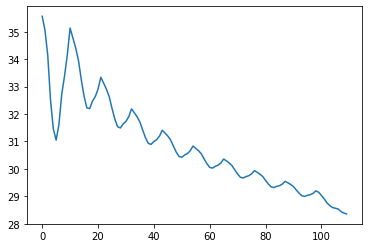

In [1333]:
plt.plot(scores)

# Train the transformer on language

In [680]:
batch = next(iter(train_iter))
input_seq = batch.English.transpose(0,1)
input_pad = EN_TEXT.vocab.stoi['<pad>']
# creates mask with 0s wherever there is padding in the input
input_msk = (input_seq != input_pad).unsqueeze(1)

NameError: name 'train_iter' is not defined

In [ ]:
# create mask as before
target_seq = batch.French.transpose(0,1)
target_pad = FR_TEXT.vocab.stoi['<pad>']
target_msk = (target_seq != target_pad).unsqueeze(1)
size = target_seq.size(1) # get seq_len for matrix
nopeak_mask = np.triu(np.ones(1, size, size),k=1).astype('uint8')
nopeak_mask = Variable(torch.from_numpy(nopeak_mask) == 0)
target_msk = target_msk & nopeak_mask

In [ ]:
d_model = 512
heads = 8
N = 6
src_vocab = len(EN_TEXT.vocab)
trg_vocab = len(FR_TEXT.vocab)
model = Transformer(src_vocab, trg_vocab, d_model, N, heads)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
# this code is very important! It initialises the parameters with a
# range of values that stops the signal fading or getting too big.
# See this blog for a mathematical explanation.
optim = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [ ]:
def train_model(epochs, print_every=100):
    
    model.train()
    
    start = time.time()
    temp = start
    
    total_loss = 0
    
    for epoch in range(epochs):
       
        for i, batch in enumerate(train_iter):
            src = batch.English.transpose(0,1)
            trg = batch.French.transpose(0,1)
            # the French sentence we input has all words except
            # the last, as it is using each word to predict the next
            
            trg_input = trg[:, :-1]
            
            # the words we are trying to predict
            
            targets = trg[:, 1:].contiguous().view(-1)
            
            # create function to make masks using mask code above
            
            src_mask, trg_mask = create_masks(src, trg_input)
            
            preds = model(src, trg_input, src_mask, trg_mask)
            
            optim.zero_grad()
            
            loss = F.cross_entropy(preds.view(-1, preds.size(-1)),
            results, ignore_index=target_pad)
            loss.backward()
            optim.step()
            
            total_loss += loss.data[0]
            if (i + 1) % print_every == 0:
                loss_avg = total_loss / print_every
                print("time = %dm, epoch %d, iter = %d, loss = %.3f,
                %ds per %d iters" % ((time.time() - start) // 60,
                epoch + 1, i + 1, loss_avg, time.time() - temp,
                print_every))
                total_loss = 0
                temp = time.time()